# DVH Analysis Example

This notebook demonstrates how to compute and plot a DVH (Dose Volume Histogram).

## Import Modules

In [1]:
try:
    import platipy
except:
    !pip install git+https://github.com/pyplati/platipy.git
    import platipy

import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk

%matplotlib inline

from platipy.imaging.tests.data import get_hn_nifti
from platipy.imaging import ImageVisualiser
from platipy.imaging.label.utils import get_com
from platipy.imaging.dose.dvh import calculate_dvh_for_labels, calculate_d_x, calculate_v_x

## Download Test Data

This will download some data from the TCIA TCGA-HNSC dataset. The data is for one patient and
contains a CT, dose and some structures.

In [2]:
data_path = get_hn_nifti()

## Load data

Let's read in the data that we've downloaded

In [3]:
test_pat_path = data_path.joinpath("TCGA_CV_5977")

ct_image = sitk.ReadImage(str(test_pat_path.joinpath("IMAGES/TCGA_CV_5977_1_CT_ONC_NECK_NECK_4.nii.gz")))

dose = sitk.ReadImage(str(test_pat_path.joinpath("DOSES/TCGA_CV_5977_1_PLAN.nii.gz")))

dose = sitk.Resample(dose, ct_image)

structure_names =["BRAINSTEM", "MANDIBLE", "CTV_60_GY", "PTV60", "CORD", "L_PAROTID", "R_PAROTID"]

structures = {
    s: sitk.ReadImage(str(test_pat_path.joinpath("STRUCTURES", f"TCGA_CV_5977_1_RTSTRUCT_{s}.nii.gz"))) for s in structure_names
}

## Visualise data

and now let's visualise the data we've got

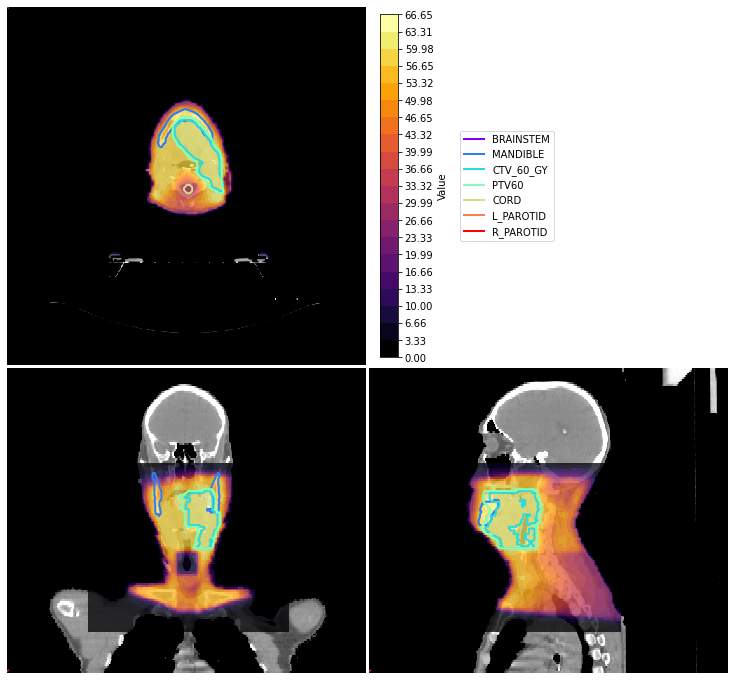

In [4]:
vis = ImageVisualiser(ct_image, cut=get_com(structures["PTV60"]))

vis.add_scalar_overlay(dose, discrete_levels=20, colormap=plt.cm.get_cmap("inferno"))
vis.add_contour(structures)

fig = vis.show()

## Compute DVH

here we compute the DVH using the dose and structures loaded. We get the DVH back in a pandas
DataFrame object.

In [5]:
dvh = calculate_dvh_for_labels(dose, structures)

## Plot DVH

using the pandas DataFrame, we plot the DVH here

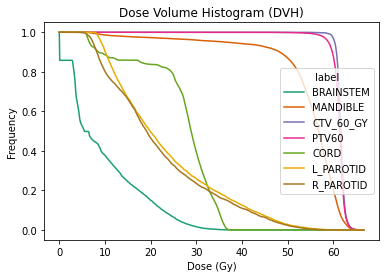

In [6]:
plt_dvh = dvh.melt(id_vars=["label", "cc", "mean"], var_name="bin", value_name="dose")
plt = sns.lineplot(data=plt_dvh, x="bin", y="dose", hue="label", palette="Dark2")
text = plt.set(xlabel="Dose (Gy)", ylabel="Frequency", title="Dose Volume Histogram (DVH)")

## DVH Metrics

Finally, we extract commonly used metrics from the DVH, such as D95 or V40.

In [7]:
df_metrics = calculate_d_x(dvh, 95)
df_metrics = df_metrics.append(calculate_v_x(dvh, 40))
df_metrics

,label,metric,value
0,BRAINSTEM,D95,0.000000
1,MANDIBLE,D95,36.500000
2,CTV_60_GY,D95,60.200000
3,PTV60,D95,58.900000
4,CORD,D95,6.500000
5,L_PAROTID,D95,9.100000
6,R_PAROTID,D95,7.300000
0,BRAINSTEM,V40,0.000000
1,MANDIBLE,V40,59.137344
2,CTV_60_GY,V40,190.980434
